# Getting Started: Pixel-Level Segmentation (Task 2)


<br>
<a href="https://colab.research.google.com/github/MTNeuro/MTNeuro/tree/main/notebooks/task2_getting_started.ipynb">
    <img align="left" alt="Open in Colab button" src="https://colab.research.google.com/assets/colab-badge.svg" width="150" height="60">
</a>
<br>    

This **MTNeuro** jupyter notebook takes you through how you can execute `task 2` by loading your preferred model and training, and evaluating it.

For more details on the tasks and dataset, please refer to our paper:

    "Quesada, J., Sathidevi, L., Liu, R., Ahad, N., Jackson, J.M., Azabou, M., ... & Dyer, E. L. (2022). MTNeuro: A Benchmark for Evaluating Representations of Brain Structure Across Multiple Levels of Abstraction. Thirty-sixth Conference on Neural Information Processing Systems Datasets and Benchmarks Track."

### Clone MTNeuro repo and Install the MTNeuro package

In [ ]:
!git clone https://github.com/MTNeuro/MTNeuro && cd MTNeuro && pip install -e .

### Importing required packages


In [1]:
#import libraries and set random seed
import sys
import matplotlib.pyplot as plt
import numpy as np
import json as json
from tqdm import tqdm

#pytorch imports
import torch
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

sys.path.append('./MTNeuro/')                 #setting the location to look for the required packages
#BossDB library and MTNeuro dataset loader
from intern import array
from MTNeuro.bossdbdataset import BossDBDataset               

from MTNeuro.trainer import Trainer                    #trainer function used to train the models
import MTNeuro.models    

import segmentation_models_pytorch as smp      #SMP library (used for calculation of performance metrics: https://github.com/qubvel/segmentation_models.pytorch

from sklearn.metrics import ConfusionMatrixDisplay


## Loading the Configurations for training a Pytorch Model


U-Net model from https://github.com/johschmidt42/PyTorch-2D-3D-UNet-Tutorial
is used as an example model for demonstrating data access and training. It is sepcified using the network config file.

The task config file is loaded to specify settings related to the training and data. 

Each configuration: `2D`, `3D`, `3class` & `4class`, has its own task configuration file.
For more details please refer to the Appendix of our `MTNeuro` paper.

**Execute the cell corresponding to the setting that you want to load**

### For training a 2D Model in 4-Class Setting

In [2]:
##load the task config for 2D 4-class setting that specifies the x,y ranges to pick from the data for forming the slices
task_config = json.load(open('./MTNeuro/MTNeuro/taskconfig/task2_2D_4class.json'))

##Load the network config for the 2D model for 4-class setting, with the batch size and model config information
network_config = json.load(open('./MTNeuro/MTNeuro/networkconfig/UNet_2D_4class.json'))

### For training a 2D model in 3-Class Setting 

In [29]:
##load the task config for 2D 3-class setting that specifies the x,y ranges to pick from the data for forming the slices
task_config = json.load(open('./MTNeuro/MTNeuro/taskconfig/task2_2D_3class.json'))

##Load the network config for the 2D model for 3-class setting, with the batch size and model config information
network_config = json.load(open('./MTNeuro/MTNeuro/networkconfig/UNet_2D_3class.json'))

### For training a 3D model in 4-Class Setting 

In [30]:
##load the task config for 3D 4-class setting that specifies the x,y ranges to pick from the data for forming the slices
task_config = json.load(open('./MTNeuro/MTNeuro/taskconfig/task2_3D_4class.json'))

##Load the network config for the 3D model for 4-class setting, with the batch size and model config information
network_config = json.load(open('./MTNeuro/MTNeuro/networkconfig/UNet_3D_4class.json'))

### For training a 3D model in 3-Class Setting 

In [31]:
##load the task config for 3D 3-class setting that specifies the x,y ranges to pick from the data for forming the slices
task_config = json.load(open('./MTNeuro/MTNeuro/taskconfig/task2_3D_3class.json'))

##Load the network config for the 3D model for 3-class setting, with the batch size and model config information
network_config = json.load(open('./MTNeuro/MTNeuro/networkconfig/UNet_3D_3class.json'))

## Load the Data using the BossDB dataloader

Here by specifying `train`, `test`, `val` in the `BossDBDatset` class arguments, we can get the corresponding set of slices downloaded. This downlaoded data can be easily converted to a PyTorch dataloader using `DataLoader` method. 

In [3]:
####Load the data for task 2

##Set-up the train dataloader and validation dataloader
train_data =  BossDBDataset(task_config, None, 'train')
val_data = BossDBDataset(task_config, None, 'val')

train_dataloader = DataLoader(dataset=train_data,
                                        batch_size=network_config['batch_size'],
                                        shuffle=False)
validation_dataloader = DataLoader(dataset=val_data,
                                        batch_size=network_config['batch_size'],
                                        shuffle=False)

Understand the data:

In [4]:
#access the input and the groundtruth of first batch
x,y = next(iter(train_dataloader))

#shape of the batch
print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}')
print(f'y = shape: {y.shape}; classes: {y.unique()}; type: {y.dtype}')
print(f'y = min: {y.min()}; max: {y.max()}')

x = shape: torch.Size([8, 1, 256, 256]); type: torch.float32
x = min: 0.0; max: 0.9490196108818054
y = shape: torch.Size([8, 256, 256]); classes: tensor([0, 1, 2]); type: torch.int64
y = min: 0; max: 2


## Visualize the data

### Visualize the a slice from the first batch and its groundtruth annotation

We can use `matplotlib` and `imshow` for this.

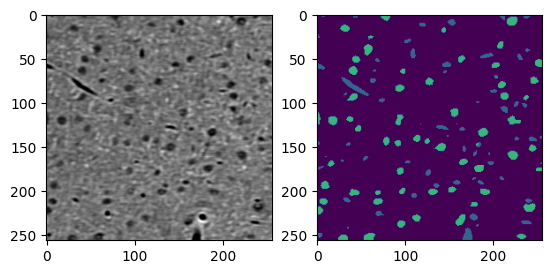

In [5]:
plt.subplot(1,2,1)
plt.imshow(x.squeeze()[0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(y.squeeze()[0], vmin=0, vmax=3)

### Create a collage of random slices from the training data

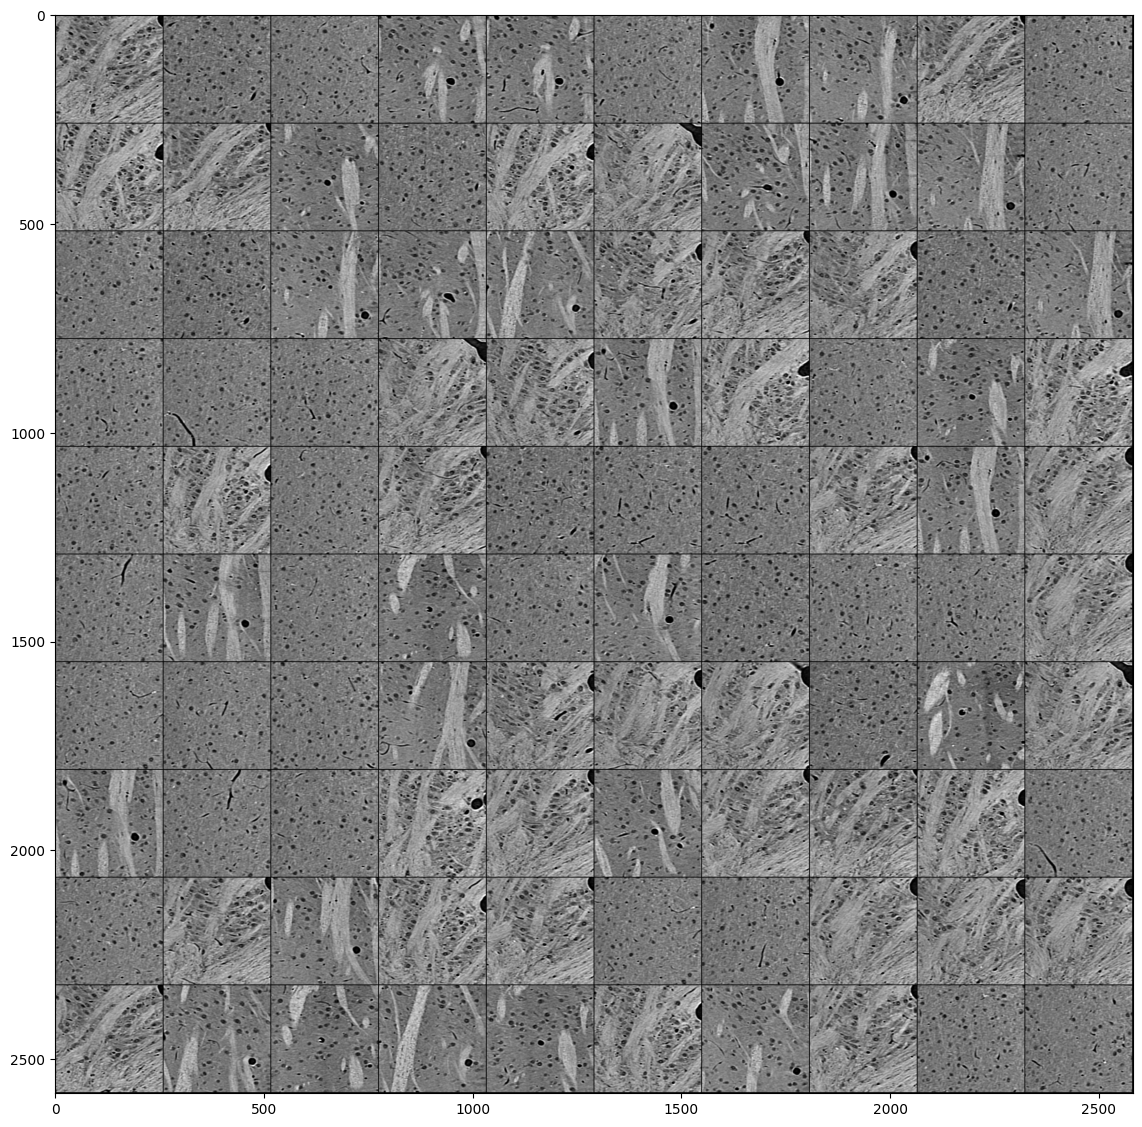

In [6]:
import random

#reshape data and select a random subset of 100 slices
if network_config['dim']==3:
    reshaped_data = []
    for data in train_data:
        reshaped_data = reshaped_data + list(data[0][0])

if network_config['dim']==2:
    #reshaped_data = torch.reshape(torch.stack(random.sample([data[0][0] for data in train_data], 100)), shape=(-1,256, 256))
    reshaped_data = [data[0][0] for data in train_data]
random_samples_from_data = random.sample(reshaped_data,100)
    
grid_img = make_grid(torch.stack(random_samples_from_data).unsqueeze(1), nrow=10)
plt.figure(figsize=(14,14))
plt.imshow(grid_img[0], cmap='gray')


## Load the model 

Here the model is loaded to the GPU if available else it's loaded to the CPU. We can load the UNet as `MTNeuro.models.UNet`

In [ ]:
## Specify the device to run the model on
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Load the model with the configuration specifiedd through UNet_2D.json
print('loading UNet model')
model = MTNeuro.models.UNet(in_channels=network_config['in_channels'],
            out_channels=network_config['classes'],
            n_blocks=network_config['n_blocks'],
            start_filters=network_config['start_filters'],
            activation=network_config['activation'],
            normalization=network_config['normalization'],
            conv_mode=network_config['conv_mode'],
            dim=network_config['dim']).to(device)
print('Done loading the model')

## Set the Loss criteria and the Optimizer

Loss criteria is also specified in the `network_config`

In [8]:
# criterion
criterion = torch.nn.CrossEntropyLoss()

# optimizer (picks the required information from the network config file UNet_2D.json)
if network_config["optimizer"] == "SGD":
    optimizer = torch.optim.SGD(model.parameters(), lr=network_config["learning_rate"])
if network_config["optimizer"] == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=network_config["learning_rate"], betas=(network_config["beta1"],network_config["beta2"]))
 

## Train the model

We use a `Trainer` method to execute the training on the loaded model.

In [ ]:
###Configure the trainer
trainer = Trainer(model=model,
                    device=device,
                    criterion=criterion,
                    optimizer=optimizer,
                    training_DataLoader=train_dataloader,
                    validation_DataLoader=validation_dataloader,
                    lr_scheduler=None,
                    epochs=network_config["epochs"],
                    notebook=True)

# start training
training_losses, validation_losses, lr_rates = trainer.run_trainer()


### Evaluate the model

Specify the method to use for making predictions using the trained model.

In [10]:
#function to predict using trained model
def predict(img, model, device):
        model.eval()
        x = img.to(device)            #send input to device
        with torch.no_grad():
            out = model(x)            #model forward pass

        out_argmax = torch.argmax(out, dim=1)  #perform softmax on outputs
        return out_argmax

Predict on the test set.

In [ ]:
#take and save the predictions and corresponding metrics
#load the test data
test_data =  BossDBDataset(task_config, None, "test")
test_dataloader = DataLoader(dataset=test_data,
                                        batch_size=network_config['batch_size'],
                                        shuffle=False)
 
batch_iter = tqdm(enumerate(test_dataloader), 'test', total=len(test_dataloader), leave=False)
#variables for storing the True Postive, False Positive, False Negative and True Negative scores respectively
tp_tot = torch.empty(0,network_config['classes'])
fp_tot = torch.empty(0,network_config['classes'])
fn_tot = torch.empty(0,network_config['classes'])
tn_tot = torch.empty(0,network_config['classes'])

for i, (x, y) in batch_iter:
    target = y.to(device) #can do this on CPU
    with torch.no_grad():
        #pass the input image through the model and get the output image
        output = predict(x, model, device)
        #calculate the true positive, false positive and false negative
        tp, fp, fn, tn = smp.metrics.get_stats(output, target, mode='multiclass', num_classes = network_config['classes'])
        tp_tot = torch.vstack((tp_tot,tp))
        fp_tot = torch.vstack((fp_tot,fp))
        fn_tot = torch.vstack((fn_tot,fn))
        tn_tot = torch.vstack((tn_tot,tn))

### Calculate Performance Metrics
 
$ Accuracy\ =\ ( tp + tn )\ /\ ( tp + tn + fp + fn ) $

$ Balanced\ Accuracy\ =\ (Specificity + Sensitivity )\ /\ 2 $

$ F1\ score\ =\ 2\ \times\ precision\ \times\ recall\ /\ (precision + recall) $

$ IoU\ score\ =\ tp\ /\ (fp + fn + tp) $

In [ ]:
# Accuracy: (tp + fp) / (fp + tn + fn + tp)
acc = (tp_tot.mean(dim=0)+tn_tot.mean(dim=0))/(fp_tot.mean(dim=0)+tn_tot.mean(dim=0)+fn_tot.mean(dim=0)+tp_tot.mean(dim=0)) 
print('Accuracy per Class:')
print(np.array(acc.cpu()))

# Balanced Accuracy:  (Specificity + Sensitivity) / 2
spec =  (tn_tot[:,1:].mean())/(fp_tot[:,1:].mean()+tn_tot[:,1:].mean())
sens =  (tp_tot[:,1:].mean())/(fn_tot[:,1:].mean()+tp_tot[:,1:].mean())
balacc = (spec + sens)/2
print(f'Balanced accuracy (No background): {balacc}')

# F1-score: 2* precision * recall / (precision + recall)
prec = tp_tot.mean(dim=0)/(fp_tot.mean(dim=0)+tp_tot.mean(dim=0))
reca = tp_tot.mean(dim=0)/(fn_tot.mean(dim=0)+tp_tot.mean(dim=0))
f1 = (2*reca*prec)/(reca+prec)
print(f'F1-score: {np.array(f1.cpu())} Avg. F1-score: {f1.mean()}')

# IoU: tp /(fp + fn + tp)
iou = (tp_tot.mean(0))/(fp_tot.mean(0)+fn_tot.mean(0)+tp_tot.mean(0))
print(f'IoU: {np.array(iou.cpu())} Avg. IoU-score: {iou.mean()}')